In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

# Input Data

Grid Properties:

In [3]:
xdelta = np.array([750,1000,1250])
ydelta = np.array([750,1000,1250])
zdelta = 20

Reservoir Rock Properties:

In [4]:
xperm = np.array([50,100,200,100,150,250,150,200,300])
yperm = xperm/2
zperm = xperm/10

In [5]:
poro = np.array([0.15,0.18,0.20,0.17,0.20,0.22,0.22,0.25,0.26])

Fluid Properties

In [6]:
visc = 5

# Configuration

In the configuration process, we ensure that the interface adheres to oilfield units, while the only underscored property is maintained in SI units.

### Creating Grids

To achieve the above objective, we first define a base Grid class that serves as the interface for a user.

In [7]:
class GridBase():

	def __init__(self,xdelta,ydelta,zdelta):
		"""Initialize grid deltas in feet. Internally stored in meters."""
		self.xdelta = xdelta # ft
		self.ydelta = ydelta # ft
		self.zdelta = zdelta # ft
		
	@property
	def xdelta(self):
		return self._xdelta/0.3048

	@xdelta.setter
	def xdelta(self,value):
		self._xdelta = np.asarray(value).flatten().astype(np.float64)*0.3048

	@property
	def ydelta(self):
		return self._ydelta/0.3048

	@ydelta.setter
	def ydelta(self,value):
		self._ydelta = np.asarray(value).flatten().astype(np.float64)*0.3048

	@property
	def zdelta(self):
		return self._zdelta/0.3048

	@zdelta.setter
	def zdelta(self,value):
		self._zdelta = np.asarray(value).flatten().astype(np.float64)*0.3048

Next, we define a Grid class that inherits from GridBase and is utilized by the solver's assembler.

In [8]:
class Grid(GridBase):

    def __init__(self,plat,*args):        
        super().__init__(*args)
        self.plat = plat
        self.volume = None
		
    @property
    def volume(self):
        return self._volume*35.3147

    @volume.setter
    def volume(self,value):
        self._volume = np.prod((self._xdelta,self._ydelta,self._zdelta),axis=0)

    @property
    def nums(self):
        """Returns total number of grids."""
        return self._xdelta.size

    @property
    def dims(self):
        return int(self.plat.shape[1]/2)

    @property
    def index(self):
        return np.arange(self.nums)

Finally, we define the GridDelta class, which returns an instance of the Grid class when referenced.

In [9]:
class GridDelta(GridBase):
	"""Gridding based on delta values."""
	def __init__(self,xdelta,ydelta,zdelta):
		super().__init__(xdelta,ydelta,zdelta)	

	@property
	def nums(self):
		"""Returns tuple of (xnums,ynums,znums)."""
		return (self.xnums,self.ynums,self.znums)

	@property
	def xnums(self):
		return self._xdelta.size

	@property
	def ynums(self):
		return self._ydelta.size

	@property
	def znums(self):
		return self._zdelta.size

	@property
	def dims(self) -> int:
		"""Returns the number of dimensions based on self.nums."""
		return next((i+1 for i in range(2,-1,-1) if self.nums[i]>1),1)

	@property
	def index(self):
		return np.arange(np.prod(self.nums))

	@property
	def grid(self):

		xdelta = np.tile(self.xdelta,self.ynums*self.znums)
		ydelta = np.tile(np.repeat(self.ydelta,self.xnums),self.znums)
		zdelta = np.repeat(self.zdelta,self.xnums*self.ynums)

		return Grid(self.plat,xdelta,ydelta,zdelta)

	@property
	def plat(self):
		"""Plat of grids that locates neighbor index information."""
		map_ = np.tile(self.index,(self.dims*2,1)).T

		map_[self.index.reshape(-1,self.xnums)[:,1:].ravel(),0] -= 1
		map_[self.index.reshape(-1,self.xnums)[:,:-1].ravel(),1] += 1

		if self.dims>1:
			map_[self.index.reshape(self.znums,-1)[:,self.xnums:],2] -= self.xnums
			map_[self.index.reshape(self.znums,-1)[:,:-self.xnums],3] += self.xnums

		if self.dims>2:
			map_[self.index.reshape(self.znums,-1)[1:,:],4] -= self.xnums*self.ynums
			map_[self.index.reshape(self.znums,-1)[:-1,:],5] += self.xnums*self.ynums

		return map_

Now, let us utilize the GridDelta class with the provided input data.

In [10]:
delta = GridDelta(xdelta,ydelta,20)

In [11]:
delta.xdelta

array([ 750., 1000., 1250.])

In [12]:
delta.ydelta

array([ 750., 1000., 1250.])

In [13]:
delta.dims

2

In [14]:
delta.grid.dims

2

In [15]:
delta.grid.volume

array([11250010.60135316, 15000014.13513754, 18750017.66892192,
       15000014.13513754, 20000018.84685005, 25000023.55856256,
       18750017.66892192, 25000023.55856256, 31250029.4482032 ])

In [16]:
delta.index

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [17]:
delta.plat

array([[0, 1, 0, 3],
       [0, 2, 1, 4],
       [1, 2, 2, 5],
       [3, 4, 0, 6],
       [3, 5, 1, 7],
       [4, 5, 2, 8],
       [6, 7, 3, 6],
       [6, 8, 4, 7],
       [7, 8, 5, 8]])

# Reservoir Rock and Fluid Properties

We define the PorMed class, which encapsulates all the rock properties required for reservoir simulation with the interface objective in mind.

In [18]:
class PorMed():
    
    def __init__(self,xperm,poro=None,**kwargs):

        self.set_perm(xperm,**kwargs)
        
        self.poro = poro # fraction
        
    @property
    def perm(self):
        return self._perm/9.869233e-16
        
    def set_perm(self,xperm,*,yperm=None,zperm=None,yreduce:float=1.,zreduce:float=10.):
        """Assigns the permeability values in mD to the grids.
    
        xperm 	: permeability in x-direction, mD
        yperm   : permeability in y direction, mD
        zperm   : permeability in z direction, mD
    
        yreduce : xperm to yperm ratio, dimensionless
        zreduce : xperm to zperm ratio, dimensionless
    
        """
        self.xperm = xperm
        self.yperm = (yperm,yreduce)
        self.zperm = (zperm,zreduce)

        self._perm = np.column_stack((self._xperm,self._yperm,self._zperm))

    @property
    def xperm(self):
        return self._xperm/9.869233e-16

    @xperm.setter
    def xperm(self,value):
        self._xperm = value*9.869233e-16

    @property
    def yperm(self):
        return self._yperm/9.869233e-16

    @yperm.setter
    def yperm(self,value):
        self._yperm = self._xperm/value[1] if value[0] is None else value[0]*9.869233e-16
    
    @property
    def zperm(self):
        return self._zperm/9.869233e-16

    @zperm.setter
    def zperm(self,value):
        self._zperm = self._xperm/value[1] if value[0] is None else value[0]*9.869233e-16

    @property
    def poro(self):
        return self._poro
        
    @poro.setter
    def poro(self,value):
        self._poro = value

Now, let us utilize the PorMed class with the provided input data.

In [19]:
res = PorMed(xperm,yperm=yperm,zperm=zperm,poro=poro)

In [20]:
res.xperm

array([ 50., 100., 200., 100., 150., 250., 150., 200., 300.])

In [21]:
res.yperm

array([ 25.,  50., 100.,  50.,  75., 125.,  75., 100., 150.])

In [22]:
res.poro

array([0.15, 0.18, 0.2 , 0.17, 0.2 , 0.22, 0.22, 0.25, 0.26])

### Fluid Properties

The only fluid property important for now is the viscosity

In [23]:
class Fluid():

  def __init__(self,visc):
    self.visc = visc # cp

  @property
  def visc(self):
    return self._visc*1000

  @visc.setter
  def visc(self,value):
    self._visc = value/1000

Utilizing the class for the exercise

In [24]:
oil = Fluid(visc=5)

In [25]:
oil.visc

5.0

# Simulation

We define a Matrix class that facilitates interaction between the builder and the solver.

In [26]:
class Matrix():

    def __init__(self,T:np.ndarray,J:np.ndarray,A:np.ndarray,Q:np.ndarray,G:np.ndarray):
        """
        T   : Inter-block transmissibility, matrix
        J   : Productivity index, diagonal matrix
        A   : Block accumulation, diagonal matrix
        Q   : Source term, vector
        G   : Gravity term, vector
        """
        self.T = T # transmissibility
        self.J = J # productivity
        self.A = A # block accumulation
        self.Q = Q # source
        self.G = G # gravity

    @property
    def T(self):
        """Converting from SI Units to Oil Field Units."""
        return self._T*(3.28084**3)*(24*60*60)*6894.76

    @T.setter
    def T(self,value):
        self._T = value/((3.28084**3)*(24*60*60)*6894.76)

    @property
    def J(self):
        """Converting from SI Units to Oil Field Units."""
        return self._J*(3.28084**3)*(24*60*60)*6894.76

    @J.setter
    def J(self,value):
        self._J = value/((3.28084**3)*(24*60*60)*6894.76)
        
    @property
    def A(self):
        """Converting from SI Units to Oil Field Units."""
        return self._A*(3.28084**3)*(24*60*60)

    @A.setter
    def A(self,value):
        self._A = value/((3.28084**3)*(24*60*60))

    @property
    def Q(self):
        """Converting from SI Units to Oil Field Units."""
        return self._Q*(3.28084**3)*(24*60*60)

    @Q.setter
    def Q(self,value):
        self._Q = value/((3.28084**3)*(24*60*60))

    @property
    def G(self):
        """Converting from SI Units to Oil Field Units."""
        return self._G*(3.28084**3)*(24*60*60)

    @G.setter
    def G(self,value):
        self._G = value/((3.28084**3)*(24*60*60))

### Block Calculations

Block calculations are performed for transmissibility and storativity.

In [27]:
class Block():

    def __init__(self,grid,res,fluid):
        self.grid = grid
        self.res = res
        self.fluid = fluid

    def transmissibility(self):
        self._Tx = self.res._xperm*self.grid._ydelta*self.grid._zdelta/self.grid._xdelta/self.fluid._visc
        self._Ty = self.res._yperm*self.grid._zdelta*self.grid._xdelta/self.grid._ydelta/self.fluid._visc
        self._Tz = self.res._zperm*self.grid._xdelta*self.grid._ydelta/self.grid._zdelta/self.fluid._visc

    def storativity(self,tdelta:float):
        self._accumulation = (self.grid._volume*self.res._poro)/(tdelta*86400)

    @property
    def Tx(self):
        return self._Tx*(3.28084**3)*(24*60*60)*6894.76
    
    @property
    def Ty(self):
        return self._Ty*(3.28084**3)*(24*60*60)*6894.76
    
    @property
    def Tz(self):
        return self._Tz*(3.28084**3)*(24*60*60)*6894.76
    
    @property
    def accumulation(self):
        return self._accumulation*(3.28084**3)*(24*60*60)

Integrating the grid, reservoir, and oil properties into the block calculation:

In [28]:
block = Block(delta.grid,res,oil)
block.transmissibility()
block.storativity(5)

In [29]:
block.Tx

array([1.26565812, 1.89848718, 3.03757949, 3.37508832, 3.79697436,
       5.06263248, 6.32829061, 6.32829061, 7.59394873])

In [30]:
block.Ty

array([0.63282906, 1.68754416, 4.2188604 , 0.94924359, 1.89848718,
       3.95518163, 1.13909231, 2.02505299, 3.79697436])

In [31]:
block.Tz

array([ 177.98317328,  474.62179542, 1186.55448854,  474.62179542,
        949.24359084, 1977.59081424,  889.91586641, 1582.07265139,
       2966.38622136])

In [32]:
block.accumulation

array([ 337500.0324    ,  540000.05184   ,  750000.072     ,
        510000.04896   ,  800000.0768    , 1100000.1056    ,
        825000.0792    , 1250000.12      , 1625000.15600001])

### Building Matrices

Next, we define a Build class that constructs the matrices to be used in the solver.

In [38]:
class Build():

    def __init__(self,plat):
        self.plat = plat

    @property
    def nums(self):
        return self.plat.shape[0]

    @property
    def dims(self):
        return int(self.plat.shape[1]/2)

    @property
    def index(self):
        return np.arange(self.nums)

    def T(self,Tx,Ty,Tz):

        index = self.index
        
        T = np.zeros((self.nums,self.nums))

        Sxneg = index[self.plat[:,0]!=index]
        Nxneg = self.plat[self.plat[:,0]!=index,0]

        txneg = Build.harmonic_mean(Tx[Sxneg],Tx[Nxneg])
        
        T[Sxneg,Nxneg] -= txneg
        T[Sxneg,Sxneg] += txneg
        
        Sxpos = index[self.plat[:,1]!=index]
        Nxpos = self.plat[self.plat[:,1]!=index,1]

        txpos = Build.harmonic_mean(Tx[Sxpos],Tx[Nxpos])
        
        T[Sxpos,Nxpos] -= txpos
        T[Sxpos,Sxpos] += txpos
        
        Syneg = index[self.plat[:,2]!=index]
        Nyneg = self.plat[self.plat[:,2]!=index,2]

        tyneg = Build.harmonic_mean(Ty[Syneg],Ty[Nyneg])

        T[Syneg,Nyneg] -= tyneg
        T[Syneg,Syneg] += tyneg
        
        Sypos = index[self.plat[:,3]!=index]
        Nypos = self.plat[self.plat[:,3]!=index,3]

        typos = Build.harmonic_mean(Ty[Sypos],Ty[Nypos])

        T[Sypos,Nypos] -= typos
        T[Sypos,Sypos] += typos

        return T

    def A(self,accumulation):

        A = np.zeros((self.nums,self.nums))

        A[self.index,self.index] = accumulation

        return A

    @staticmethod
    def harmonic_mean(term1,term2):
        """Returns harmonic mean of two terms, term1 and term 2."""
        return (2*term1*term2)/(term1+term2)

In [39]:
build = Build(block.grid.plat)

In [40]:
T = build.T(block.Tx,block.Ty,block.Tx); T

array([[ 2.27818462, -1.51878975,  0.        , -0.75939487,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-1.51878975,  5.64220082, -2.33659961,  0.        , -1.78681147,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -2.33659961,  6.41936774,  0.        ,  0.        ,
        -4.08276813,  0.        ,  0.        ,  0.        ],
       [-0.75939487,  0.        ,  0.        ,  5.36855627, -3.57362293,
         0.        , -1.03553846,  0.        ,  0.        ],
       [ 0.        , -1.78681147,  0.        , -3.57362293, 11.65956237,
        -4.33939927,  0.        , -1.9597287 ,  0.        ],
       [ 0.        ,  0.        , -4.08276813,  0.        , -4.33939927,
        12.29663104,  0.        ,  0.        , -3.87446364],
       [ 0.        ,  0.        ,  0.        , -1.03553846,  0.        ,
         0.        ,  7.36382907, -6.32829061,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -1

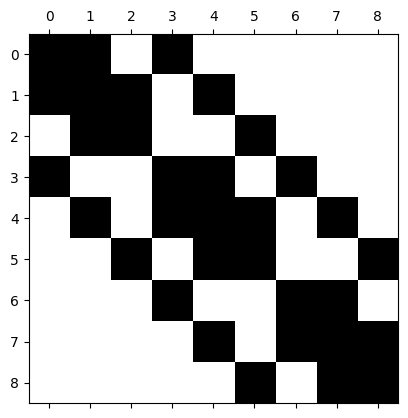

In [41]:
plt.spy(T)

In [42]:
A = build.A(block.accumulation); A

array([[ 337500.0324    ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ],
       [      0.        ,  540000.05184   ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,  750000.072     ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ,
         510000.04896   ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ,
              0.        ,  800000.0768    ,       0.        ,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ,
   

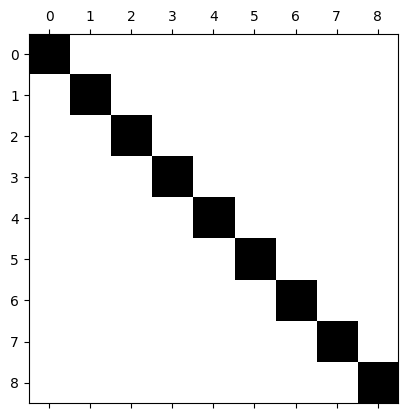

In [43]:
plt.spy(A)